In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Flatten
from tensorflow.keras.optimizers import Adam

# Hyperparameters
latent_dim = 100  # Dimension of the latent space (random noise input)
signal_length = 128  # Length of the generated chaotic signal

# Generate logistic map signals
def generate_logistic_map_signals(n_samples=1000, signal_length=128, r=3.9):
    """Generate chaotic signals using the logistic map."""
    signals = []
    for _ in range(n_samples):
        x = np.random.uniform(0, 1)  # Initial condition
        signal = []
        for _ in range(signal_length):
            x = r * x * (1 - x)
            signal.append(x)
        signals.append(signal)
    return np.array(signals)

# Generator model
def build_generator(latent_dim, signal_length):
    model = Sequential([
        Dense(64, input_dim=latent_dim),
        LeakyReLU(0.2),
        Dense(128),
        LeakyReLU(0.2),
        Dense(signal_length, activation='linear')  # No range restriction
    ])
    return model

# Discriminator model
def build_discriminator(signal_length):
    model = Sequential([
        Flatten(input_shape=(signal_length,)),
        Dense(128),
        LeakyReLU(0.2),
        Dense(64),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model

# GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    return model

# Compile models
def compile_models(generator, discriminator, gan):
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    discriminator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    gan.compile(optimizer=opt, loss='binary_crossentropy')

# Training function
from sklearn.metrics import precision_score, recall_score

def train_gan(generator, discriminator, gan, epochs=10000, batch_size=32):
    real_data = generate_logistic_map_signals(batch_size * 10, signal_length)

    for epoch in range(epochs):
        # Train discriminator
        real_samples = real_data[np.random.randint(0, real_data.shape[0], batch_size)]
        fake_samples = generator.predict(np.random.normal(0, 1, (batch_size, latent_dim)))
        X = np.vstack((real_samples, fake_samples))
        y_true = np.vstack((np.ones((batch_size, 1)), np.zeros((batch_size, 1))))

        # Train discriminator on the combined dataset
        y_pred = discriminator.predict(X) > 0.5  # Predicted labels (True for real, False for fake)
        d_loss, d_accuracy = discriminator.train_on_batch(X, y_true)

        # Compute precision and recall
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        y_gan = np.ones((batch_size, 1))  # Trick GAN to think generated signals are real
        g_loss = gan.train_on_batch(noise, y_gan)

        # Log progress
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch {epoch + 1}, "
                  f"D Loss: {d_loss}, D Accuracy: {d_accuracy}, "
                  f"D Precision: {precision}, D Recall: {recall}, "
                  f"G Loss: {g_loss}")


# Instantiate models
generator = build_generator(latent_dim, signal_length)
discriminator = build_discriminator(signal_length)
gan = build_gan(generator, discriminator)

compile_models(generator, discriminator, gan)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
discriminator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,833 (97.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,833 (97.00 KB)

In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,296 (122.25 KB)

 Trainable params: 31,296 (122.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

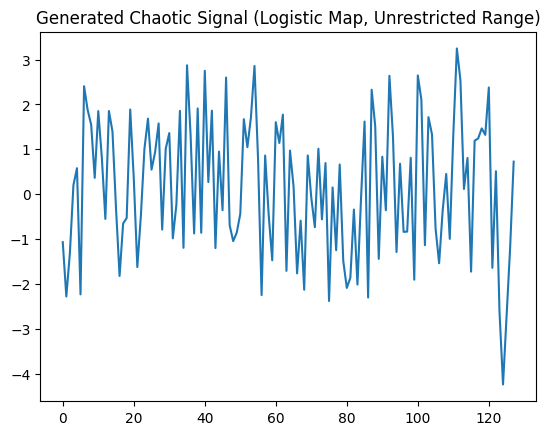

In [ ]:

# Train the GAN
train_gan(generator, discriminator, gan, epochs=2000, batch_size=32)

# Generate and plot a signal
noise = np.random.normal(0, 1, (1, latent_dim))
generated_signal = generator.predict(noise).flatten()
plt.plot(generated_signal)
plt.title("Generated Chaotic Signal (Logistic Map, Unrestricted Range)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


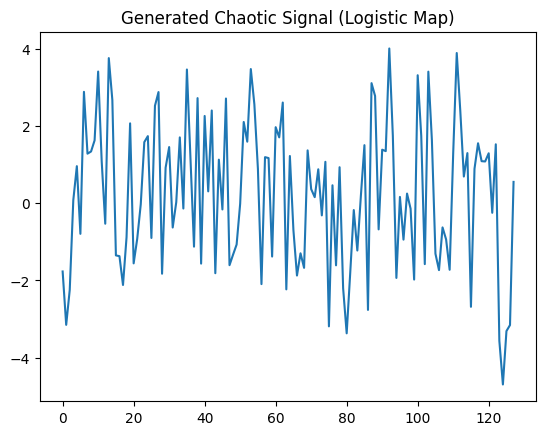

In [5]:
noise = np.random.normal(0, 1, (1, latent_dim))
generated_signal = generator.predict(noise).flatten()
plt.plot(generated_signal)
plt.title("Generated Chaotic Signal (Logistic Map)")
plt.show()